In [1]:
DEBUG = False
MODEL = "CHRONOS"   # CHRONOS or TABPFN

In [2]:
import json

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# short_datasets = "m4_yearly m4_quarterly m4_monthly m4_weekly m4_daily m4_hourly electricity/15T electricity/H electricity/D electricity/W solar/10T solar/H solar/D solar/W hospital covid_deaths us_births/D us_births/M us_births/W saugeenday/D saugeenday/M saugeenday/W temperature_rain_with_missing kdd_cup_2018_with_missing/H kdd_cup_2018_with_missing/D car_parts_with_missing restaurant hierarchical_sales/D hierarchical_sales/W LOOP_SEATTLE/5T LOOP_SEATTLE/H LOOP_SEATTLE/D SZ_TAXI/15T SZ_TAXI/H M_DENSE/H M_DENSE/D ett1/15T ett1/H ett1/D ett1/W ett2/15T ett2/H ett2/D ett2/W jena_weather/10T jena_weather/H jena_weather/D bitbrains_fast_storage/5T bitbrains_fast_storage/H bitbrains_rnd/5T bitbrains_rnd/H bizitobs_application bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"
short_datasets = "m4_weekly"

# med_long_datasets = "electricity/15T electricity/H solar/10T solar/H kdd_cup_2018_with_missing/H LOOP_SEATTLE/5T LOOP_SEATTLE/H SZ_TAXI/15T M_DENSE/H ett1/15T ett1/H ett2/15T ett2/H jena_weather/10T jena_weather/H bitbrains_fast_storage/5T bitbrains_rnd/5T bizitobs_application bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"
med_long_datasets = "bizitobs_l2c/H"

# Get union of short and med_long datasets
all_datasets = list(set(short_datasets.split() + med_long_datasets.split()))

if DEBUG:
    all_datasets = ["bizitobs_l2c/H"]

dataset_properties_map = json.load(open("dataset_properties.json"))

In [3]:
from gluonts.ev.metrics import (
    MAE,
    MAPE,
    MASE,
    MSE,
    MSIS,
    ND,
    NRMSE,
    RMSE,
    SMAPE,
    MeanWeightedSumQuantileLoss,
)

# Instantiate the metrics
metrics = [
    MSE(forecast_type="mean"),
    MSE(forecast_type=0.5),
    MAE(),
    MASE(),
    MAPE(),
    SMAPE(),
    MSIS(),
    RMSE(),
    NRMSE(),
    ND(),
    MeanWeightedSumQuantileLoss(
        quantile_levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    ),
]

In [4]:
from gift_eval.data import Dataset

ds_name = "m4_weekly"
term = "short"
is_univariate = dataset_properties_map[ds_name]["num_variates"] > 1

dataset = Dataset(
    name=ds_name,
    term=term,
    to_univariate=is_univariate,
)

### Playground

In [5]:
# import pandas as pd
# from autogluon.timeseries import TimeSeriesDataFrame

# for input, _ in dataset.test_data:
#     debug_input = input
#     break

# TimeSeriesDataFrame(pd.DataFrame({
#     'item_id': debug_input['item_id'],
#     'target': debug_input['target'],
#     'timestamp': pd.date_range(
#         start=debug_input['start'].to_timestamp(),
#         periods=len(debug_input['target']),
#         freq=debug_input['freq']
#     )
# }).set_index(["item_id", "timestamp"])).slice_by_timestep(-10, None).head()


## Chronos Predictor (for debugging)

In [6]:
from dataclasses import dataclass, field
from typing import List, Optional

import numpy as np
import torch
from chronos import BaseChronosPipeline, ForecastType
from gluonts.itertools import batcher
from gluonts.model import Forecast
from gluonts.model.forecast import QuantileForecast, SampleForecast
from tqdm.auto import tqdm


@dataclass
class ModelConfig:
    quantile_levels: Optional[List[float]] = None
    forecast_keys: List[str] = field(init=False)
    statsforecast_keys: List[str] = field(init=False)
    intervals: Optional[List[int]] = field(init=False)

    def __post_init__(self):
        self.forecast_keys = ["mean"]
        self.statsforecast_keys = ["mean"]
        if self.quantile_levels is None:
            self.intervals = None
            return

        intervals = set()

        for quantile_level in self.quantile_levels:
            interval = round(200 * (max(quantile_level, 1 - quantile_level) - 0.5))
            intervals.add(interval)
            side = "hi" if quantile_level > 0.5 else "lo"
            self.forecast_keys.append(str(quantile_level))
            self.statsforecast_keys.append(f"{side}-{interval}")

        self.intervals = sorted(intervals)


class ChronosPredictor:
    def __init__(
        self,
        model_path,
        num_samples: int,
        prediction_length: int,
        *args,
        **kwargs,
    ):
        print("prediction_length:", prediction_length)
        self.pipeline = BaseChronosPipeline.from_pretrained(
            model_path,
            *args,
            **kwargs,
        )
        self.prediction_length = prediction_length
        self.num_samples = num_samples

    def predict(self, test_data_input, batch_size: int = 1024) -> List[Forecast]:
        pipeline = self.pipeline
        predict_kwargs = (
            {"num_samples": self.num_samples}
            if pipeline.forecast_type == ForecastType.SAMPLES
            else {}
        )
        while True:
            try:
                # Generate forecast samples
                forecast_outputs = []
                for batch in tqdm(batcher(test_data_input, batch_size=batch_size)):
                    context = [torch.tensor(entry["target"]) for entry in batch]
                    forecast_outputs.append(
                        pipeline.predict(
                            context,
                            prediction_length=self.prediction_length,
                            **predict_kwargs,
                        ).numpy()
                    )
                forecast_outputs = np.concatenate(forecast_outputs)
                break
            except torch.cuda.OutOfMemoryError:
                print(
                    f"OutOfMemoryError at batch_size {batch_size}, reducing to {batch_size // 2}"
                )
                batch_size //= 2

        print(f"forecast_outputs: {forecast_outputs.shape}")

        # Convert forecast samples into gluonts Forecast objects
        forecasts = []
        for item, ts in zip(forecast_outputs, test_data_input):
            forecast_start_date = ts["start"] + len(ts["target"])

            if pipeline.forecast_type == ForecastType.SAMPLES:
                forecasts.append(
                    SampleForecast(samples=item, start_date=forecast_start_date)
                )
            elif pipeline.forecast_type == ForecastType.QUANTILES:
                forecasts.append(
                    QuantileForecast(
                        forecast_arrays=item,
                        forecast_keys=list(map(str, pipeline.quantiles)),
                        start_date=forecast_start_date,
                    )
                )

        print(f"forecasts: {forecasts}")

        return forecasts

## TabPFN-TS Predictor

In [7]:
from typing import Iterator

import pandas as pd
from gluonts.model.forecast import Forecast
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import generate_test_X
from tabpfn_time_series import (
    TabPFNTimeSeriesPredictor,
    FeatureTransformer,
    DefaultFeatures,
    TabPFNMode,
    TABPFN_TS_DEFAULT_QUANTILE_CONFIG,
)


class TabPFNTSPredictor:
    SELECTED_FEATURES = [
        DefaultFeatures.add_running_index,
        DefaultFeatures.add_calendar_features,
    ]

    def __init__(
        self,
        ds_prediction_length: int,
        ds_freq: str,
        tabpfn_mode: TabPFNMode = TabPFNMode.CLIENT,
    ):
        self.ds_prediction_length = ds_prediction_length
        self.ds_freq = ds_freq
        self.tabpfn_predictor = TabPFNTimeSeriesPredictor(
            tabpfn_mode=tabpfn_mode,
            # max_context_length=1024,
        )

    def predict(self, test_data_input) -> Iterator[Forecast]:
        time_series = []
        for i, item in enumerate(test_data_input):
            time_series.append(pd.DataFrame({
                'item_id': i,  # Use index i as monotonic item_id
                # 'item_id': item['item_id'],
                'target': item['target'],
                'timestamp': pd.date_range(
                    start=item['start'].to_timestamp(),
                    periods=len(item['target']),
                    freq=item['freq']
                )
            }).set_index(['item_id', 'timestamp']))

        assert len(time_series) == len(test_data_input)

        time_series = pd.concat(time_series)
        train_tsdf = TimeSeriesDataFrame(time_series)
        test_tsdf = generate_test_X(train_tsdf, prediction_length=dataset.prediction_length)

        train_tsdf, test_tsdf = FeatureTransformer.add_features(
            train_tsdf, test_tsdf, self.SELECTED_FEATURES
        )

        pred: TimeSeriesDataFrame = self.tabpfn_predictor.predict(train_tsdf, test_tsdf)
        pred = pred.drop(columns=['target'])
        # pred = pred.droplevel(0)

        # print(f"pred: {pred}")

        # Reshape pred to (n_time_series, quantiles, prediction_length)
        # pred = pred.values.reshape(
        #     -1, len(TABPFN_TS_DEFAULT_QUANTILE_CONFIG), self.ds_prediction_length
        # )            

        # print("after reshape")
        # print(f"pred: {pred}")
        # pred = pd.concat(all_pred)
        # print(f"all_pred: {all_pred}")
        forecasts = []
        for item_id in pred.item_ids:
            # forecast_start_date = ts["start"] + len(ts["target"])
            forecast_start_date = pred.loc[item_id].index[0].to_period(self.ds_freq)
            print(f"pred.loc[item_id]: {pred.loc[item_id].values.T}")

            forecasts.append(QuantileForecast(
                forecast_arrays=pred.loc[item_id].values.T,
                forecast_keys=list(map(str, TABPFN_TS_DEFAULT_QUANTILE_CONFIG)),
                start_date=forecast_start_date,
            ))
    
        return forecasts


## Evaluation

In [8]:
all_datasets

['bizitobs_l2c/H', 'm4_weekly']

In [9]:
all_datasets = ['bizitobs_l2c/H']
# all_datasets = ['m4_weekly']

In [10]:
import logging


class WarningFilter(logging.Filter):
    def __init__(self, text_to_filter):
        super().__init__()
        self.text_to_filter = text_to_filter

    def filter(self, record):
        return self.text_to_filter not in record.getMessage()


gts_logger = logging.getLogger("gluonts.model.forecast")
gts_logger.addFilter(
    WarningFilter("The mean prediction is not stored in the forecast data")
)

In [11]:
import csv
import os

from gluonts.model import evaluate_model
from gluonts.time_feature import get_seasonality

from gift_eval.data import Dataset

if MODEL == "TABPFN":
    model_name = "tabpfn-ts-paper"
elif MODEL == "CHRONOS":
    model_name = "chronos-bolt-small"
else:
    raise ValueError(f"Invalid model: {MODEL}")

output_dir = f"../results/{model_name}"
os.makedirs(output_dir, exist_ok=True)

# Define the path for the CSV file
csv_file_path = os.path.join(output_dir, "all_results.csv")

pretty_names = {
    "saugeenday": "saugeen",
    "temperature_rain_with_missing": "temperature_rain",
    "kdd_cup_2018_with_missing": "kdd_cup_2018",
    "car_parts_with_missing": "car_parts",
}

with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)

    # Write the header
    writer.writerow(
        [
            "dataset",
            "model",
            "eval_metrics/MSE[mean]",
            "eval_metrics/MSE[0.5]",
            "eval_metrics/MAE[0.5]",
            "eval_metrics/MASE[0.5]",
            "eval_metrics/MAPE[0.5]",
            "eval_metrics/sMAPE[0.5]",
            "eval_metrics/MSIS",
            "eval_metrics/RMSE[mean]",
            "eval_metrics/NRMSE[mean]",
            "eval_metrics/ND[0.5]",
            "eval_metrics/mean_weighted_sum_quantile_loss",
            "domain",
            "num_variates",
        ]
    )

for ds_num, ds_name in enumerate(all_datasets):
    ds_key = ds_name.split("/")[0]
    print(f"Processing dataset: {ds_name} ({ds_num + 1} of {len(all_datasets)})")
    terms = ["short", "medium", "long"]
    for term in terms:
        if (
            term == "medium" or term == "long"
        ) and ds_name not in med_long_datasets.split():
            continue

        if "/" in ds_name:
            ds_key = ds_name.split("/")[0]
            ds_freq = ds_name.split("/")[1]
            ds_key = ds_key.lower()
            ds_key = pretty_names.get(ds_key, ds_key)
        else:
            ds_key = ds_name.lower()
            ds_key = pretty_names.get(ds_key, ds_key)
            ds_freq = dataset_properties_map[ds_key]["frequency"]
        ds_config = f"{ds_key}/{ds_freq}/{term}"

        print("ds_config", ds_config)

        # Initialize the dataset
        to_univariate = (
            False
            if Dataset(name=ds_name, term=term, to_univariate=False).target_dim == 1
            else True
        )
        dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)
        season_length = get_seasonality(dataset.freq)

        print(f"Dataset size: {len(dataset.test_data)}")
        print(f"Prediction length: {dataset.prediction_length}")


        if MODEL == "TABPFN":
            predictor = TabPFNTSPredictor(
                ds_prediction_length=dataset.prediction_length,
                ds_freq=dataset.freq,
            )
        elif MODEL == "CHRONOS":
            predictor = ChronosPredictor(
                model_path="amazon/chronos-bolt-small",
                num_samples=100,
                prediction_length=dataset.prediction_length,
            )
        else:
            raise ValueError(f"Invalid model: {MODEL}")

        res = evaluate_model(
            predictor,
            test_data=dataset.test_data,
            metrics=metrics,
            batch_size=1024,
            axis=None,
            mask_invalid_label=True,
            allow_nan_forecast=False,
            seasonality=season_length,
        )

        # Append the results to the CSV file
        with open(csv_file_path, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(
                [
                    ds_config,
                    model_name,
                    res["MSE[mean]"][0],
                    res["MSE[0.5]"][0],
                    res["MAE[0.5]"][0],
                    res["MASE[0.5]"][0],
                    res["MAPE[0.5]"][0],
                    res["sMAPE[0.5]"][0],
                    res["MSIS"][0],
                    res["RMSE[mean]"][0],
                    res["NRMSE[mean]"][0],
                    res["ND[0.5]"][0],
                    res["mean_weighted_sum_quantile_loss"][0],
                    dataset_properties_map[ds_key]["domain"],
                    dataset_properties_map[ds_key]["num_variates"],
                ]
            )

        print(f"Results for {ds_name} have been written to {csv_file_path}")

Processing dataset: bizitobs_l2c/H (1 of 1)
ds_config bizitobs_l2c/H/short
Dataset size: 42
Prediction length: 48
prediction_length: 48


0it [00:00, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


forecast_outputs: (42, 9, 48)
forecasts: [QuantileForecast(array([[-1.16223907e+00, -9.40170288e-01, -9.06852722e-01,
        -9.83404160e-01, -8.62514496e-01, -7.67536163e-01,
        -6.39219284e-01, -8.62483978e-02,  5.18819809e-01,
         1.26670551e+00,  1.96298885e+00,  2.44628525e+00,
         2.63761520e+00,  2.96445942e+00,  3.29122925e+00,
         3.40530872e+00,  3.56441879e+00,  3.90707111e+00,
         4.04279423e+00,  3.97330284e+00,  3.83209896e+00,
         4.19828129e+00,  4.70777225e+00,  5.34225273e+00,
         5.95821381e+00,  6.68825531e+00,  7.18094063e+00,
         7.46293640e+00,  7.81943703e+00,  8.09539890e+00,
         8.18957520e+00,  8.55027199e+00,  8.92973804e+00,
         9.59526348e+00,  1.02677202e+01,  1.08528557e+01,
         1.10358686e+01,  1.13139420e+01,  1.16038532e+01,
         1.18239336e+01,  1.20571194e+01,  1.23929014e+01,
         1.26611271e+01,  1.27755527e+01,  1.26328697e+01,
         1.27998810e+01,  1.29885845e+01,  1.34089975e+0

42it [00:00, 923.53it/s]

Results for bizitobs_l2c/H have been written to ../results/chronos-bolt-small/all_results.csv
ds_config bizitobs_l2c/H/medium
Dataset size: 7
Prediction length: 480
prediction_length: 480


0it [00:00, ?it/s]

/Users/shibinhoo/miniconda3/envs/gift-eval/lib/python3.10/site-packages/chronos/chronos_bolt.py:477: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


forecast_outputs: (7, 9, 480)
forecasts: [QuantileForecast(array([[ 4.320983  , -0.57956696, -2.0586681 , ..., 22.39801   ,
        22.566292  , 22.850344  ],
       [ 6.248802  ,  0.5164919 , -1.203783  , ..., 22.953283  ,
        23.0382    , 23.542303  ],
       [ 7.5002117 ,  1.3445301 , -0.59747505, ..., 23.244474  ,
        23.365692  , 23.876148  ],
       ...,
       [11.173969  ,  4.3001738 ,  1.9161253 , ..., 23.853596  ,
        24.100544  , 24.787561  ],
       [12.226746  ,  5.2323046 ,  2.8646584 , ..., 24.110466  ,
        24.456245  , 25.26139   ],
       [13.926355  ,  6.752306  ,  4.5336075 , ..., 24.682474  ,
        25.263569  , 26.094837  ]], dtype=float32)), start_date=Period('2021-01-31 00:00', 'H'), forecast_keys=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'], item_id=None, info=None), QuantileForecast(array([[-7.1320248e-01, -5.9892654e-01, -6.5032482e-01, ...,
         8.0053968e+00,  8.4720335e+00,  8.7525921e+00],
       [-5.2882290e-01, -4.

7it [00:00, 617.13it/s]

Results for bizitobs_l2c/H have been written to ../results/chronos-bolt-small/all_results.csv
ds_config bizitobs_l2c/H/long
Dataset size: 7
Prediction length: 720
prediction_length: 720


0it [00:00, ?it/s]

forecast_outputs: (7, 9, 720)
forecasts: [QuantileForecast(array([[19.45877 , 19.527382, 19.632233, ..., 22.665508, 22.62041 ,
        22.919851],
       [19.83913 , 19.919445, 20.016603, ..., 23.18247 , 23.18626 ,
        23.696465],
       [20.066181, 20.153685, 20.237804, ..., 23.291645, 23.374035,
        24.0131  ],
       ...,
       [20.77195 , 20.807035, 20.885399, ..., 23.412403, 23.648914,
        24.8513  ],
       [21.01183 , 21.027683, 21.105381, ..., 23.612906, 23.911629,
        25.257877],
       [21.407764, 21.391235, 21.486067, ..., 24.238113, 24.600414,
        26.084318]], dtype=float32)), start_date=Period('2021-01-21 00:00', 'H'), forecast_keys=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'], item_id=None, info=None), QuantileForecast(array([[16.019802 , 15.00882  , 13.758575 , ..., 10.920049 , 10.944765 ,
        10.827739 ],
       [16.879227 , 16.124819 , 15.014216 , ..., 11.586645 , 11.625835 ,
        11.500096 ],
       [17.45657  , 16.842415

7it [00:00, 575.80it/s]

Results for bizitobs_l2c/H have been written to ../results/chronos-bolt-small/all_results.csv


In [12]:
res

,MSE[mean],MSE[0.5],MAE[0.5],MASE[0.5],MAPE[0.5],sMAPE[0.5],MSIS,RMSE[mean],NRMSE[mean],ND[0.5],mean_weighted_sum_quantile_loss
None,83.099888,83.099888,5.490911,0.612126,0.621965,0.824048,12.442179,9.115914,0.556826,0.335401,0.295291


## Playground

In [13]:
from gift_eval.data import Dataset

# ds_key = "bizitobs_l2c"
# term = "short"
# ds_name = f"{ds_key}/H"

ds_key = "m4_weekly"
term = "short"
ds_name = "m4_weekly"

to_univariate = (
    False
    if Dataset(name=ds_name, term=term, to_univariate=False).target_dim == 1
    else True
)

dataset = Dataset(
    name=ds_name,
    term=term,
    to_univariate=to_univariate,
)

In [14]:
to_univariate

False

In [15]:
dataset.target_dim

1

In [16]:
for i, (input, label) in enumerate(dataset.test_data):
    debug_input = input
    debug_label = label

    # print("i", i)
    # print("debug_input", debug_input)
    # print("past_feat_dynamic_real", debug_input['past_feat_dynamic_real'].shape)
    
    if i == 10:
        break

In [17]:

# random_index = np.random.randint(0, len(dataset.test_data))
random_index = 94

for i, (test_data, label) in enumerate(dataset.test_data):
    if i != random_index:
        continue

    debug_data = test_data
    debug_label = label

    debug_data_tsdf = TimeSeriesDataFrame(pd.DataFrame({
        'item_id': debug_data['item_id'],
        'target': debug_data['target'],
        'timestamp': pd.date_range(
            start=debug_data['start'].to_timestamp(),
            periods=len(debug_data['target']),
            freq=debug_data['freq']
        )
    }).set_index(['item_id', 'timestamp']))

    debug_label_tsdf = TimeSeriesDataFrame(pd.DataFrame({
        'item_id': debug_label['item_id'],
        'target': debug_label['target'],
        'timestamp': pd.date_range(
            start=debug_label['start'].to_timestamp(),
            periods=len(debug_label['target']),
            freq=debug_label['freq']
        )
    }).set_index(['item_id', 'timestamp']))
    
    break

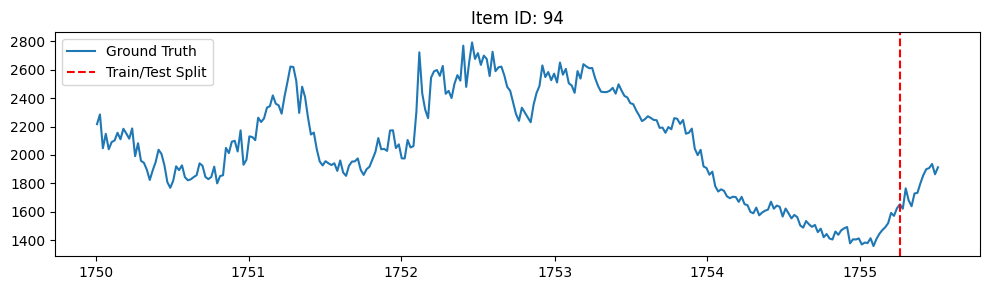

In [18]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(debug_data_tsdf, debug_label_tsdf)


In [19]:
predictor = TabPFNTSPredictor(
    ds_prediction_length=dataset.prediction_length,
    ds_freq=dataset.freq,
    # debug=DEBUG,
)

# predictor = ChronosPredictor(
#     model_path="amazon/chronos-bolt-small",
#     num_samples=100,
#     prediction_length=dataset.prediction_length,
# )

predictions = predictor.predict([debug_data])


  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████| [00:02<00:00]


pred.loc[item_id]: [[1586.57849121 1570.60217285 1548.5748291  1521.84887695 1493.41711426
  1457.7520752  1418.54492188 1397.38208008 1364.59838867 1329.72546387
  1288.81848145 1260.96533203 1238.43847656]
 [1608.8470459  1601.54956055 1589.91418457 1577.36877441 1564.70288086
  1548.63562012 1531.86865234 1523.00878906 1504.41455078 1482.73132324
  1454.42138672 1431.21228027 1405.94262695]
 [1623.76171875 1621.39648438 1615.68530273 1611.18322754 1605.31713867
  1597.95153809 1590.08105469 1587.01928711 1575.67382812 1562.66430664
  1545.47021484 1531.0847168  1509.65393066]
 [1636.28710938 1637.43359375 1636.48474121 1636.87634277 1635.92492676
  1634.12915039 1632.0020752  1632.4440918  1626.35705566 1619.91833496
  1609.26538086 1601.03771973 1582.06958008]
 [1647.59118652 1651.70947266 1654.18371582 1659.13891602 1661.86352539
  1664.17578125 1666.12927246 1669.1385498  1666.5098877  1664.03112793
  1659.31188965 1655.25952148 1642.41796875]
 [1658.76745605 1666.08276367 1672.2

In [20]:
predictions[0].forecast_array

array([[1586.57849121, 1570.60217285, 1548.5748291 , 1521.84887695,
        1493.41711426, 1457.7520752 , 1418.54492188, 1397.38208008,
        1364.59838867, 1329.72546387, 1288.81848145, 1260.96533203,
        1238.43847656],
       [1608.8470459 , 1601.54956055, 1589.91418457, 1577.36877441,
        1564.70288086, 1548.63562012, 1531.86865234, 1523.00878906,
        1504.41455078, 1482.73132324, 1454.42138672, 1431.21228027,
        1405.94262695],
       [1623.76171875, 1621.39648438, 1615.68530273, 1611.18322754,
        1605.31713867, 1597.95153809, 1590.08105469, 1587.01928711,
        1575.67382812, 1562.66430664, 1545.47021484, 1531.0847168 ,
        1509.65393066],
       [1636.28710938, 1637.43359375, 1636.48474121, 1636.87634277,
        1635.92492676, 1634.12915039, 1632.0020752 , 1632.4440918 ,
        1626.35705566, 1619.91833496, 1609.26538086, 1601.03771973,
        1582.06958008],
       [1647.59118652, 1651.70947266, 1654.18371582, 1659.13891602,
        1661.8635253

In [21]:
# Convert QuantileForecast to TimeSeriesDataFrame format
forecast = predictions[0]
forecast_df = pd.DataFrame(
    forecast.forecast_array.T,
    columns=forecast.forecast_keys,
    index=pd.date_range(
        start=forecast.start_date.to_timestamp(),
        periods=len(forecast.forecast_array[0]),
        freq=dataset.freq
    )
)
forecast_df['item_id'] = debug_data['item_id']
forecast_tsdf = TimeSeriesDataFrame(forecast_df.reset_index().rename(columns={'index': 'timestamp'}).set_index(['item_id', 'timestamp']))
forecast_tsdf['target'] = forecast_tsdf['0.5']

forecast_tsdf.head()

0.1          0.2          0.3          0.4   
item_id timestamp                                                        
94      1755-04-13  1586.578491  1608.847046  1623.761719  1636.287109  \
        1755-04-20  1570.602173  1601.549561  1621.396484  1637.433594   
        1755-04-27  1548.574829  1589.914185  1615.685303  1636.484741   
        1755-05-04  1521.848877  1577.368774  1611.183228  1636.876343   
        1755-05-11  1493.417114  1564.702881  1605.317139  1635.924927   

                            0.5          0.6          0.7          0.8   
item_id timestamp                                                        
94      1755-04-13  1647.591187  1658.767456  1670.362427  1684.478027  \
        1755-04-20  1651.709473  1666.082764  1681.796387  1700.738159   
        1755-04-27  1654.183716  1672.280518  1692.577026  1717.425293   
        1755-05-04  1659.138916  1681.671753  1706.636108  1738.625488   
        1755-05-11  1661.863525  1688.490601  1718.315918  1756.380127   

                            0.9       target  
item_id timestamp                             
94      1755-04-13  1704.134033  1647.591187  
        1755-04-20  1728.766724  1651.709473  
        1755-04-27  1756.742432  1654.183716  
        1755-05-04  1788.463745  1659.138916  
        1755-05-11  1819.292603  1661.863525

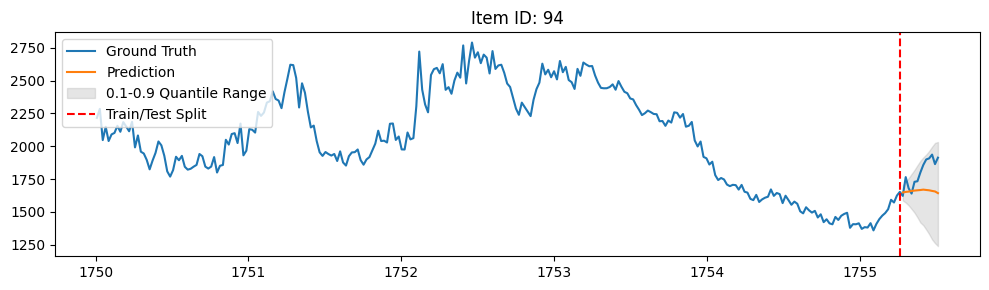

In [22]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=debug_data_tsdf,
    test=debug_label_tsdf,
    pred=forecast_tsdf,
)